In [1]:
import pandas as pd
import numpy as np
import glob
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from matplotlib import pyplot as plt
from sklearn.decomposition import PCA
import pylab as pl
import scipy.optimize as opt
from sklearn import preprocessing
%matplotlib inline
import cv2
import random
from PIL import Image
import os
from keras.preprocessing.image import ImageDataGenerator
from keras.applications.resnet import ResNet50  
from keras.layers import Flatten, Dense, GlobalMaxPooling2D, Dropout
from keras.models import Model
from keras import optimizers
import tensorflow as tf
from tensorflow import keras
from keras.models import Sequential
from keras.callbacks import ModelCheckpoint
from sklearn.model_selection import GridSearchCV
from keras.wrappers.scikit_learn import KerasClassifier
from tensorflow.keras import layers

# Data Processing

In [3]:
DATA_DIR = '../input/large-gender-face-dataset/big_face_gender_data'
print(os.listdir(path=DATA_DIR))

['Validation', 'Test', 'Train']


In [3]:
batch_size = 1024         
image_shape = (218,178)

def add_noise(img):
    VARIABILITY = 50
    deviation = VARIABILITY*random.random()
    noise = np.random.normal(0, deviation, img.shape)
    img += noise
    np.clip(img, 0., 255.)
    return img

train_datagen = ImageDataGenerator(rescale = 1./255, rotation_range=20,shear_range=0.2,
                                   zoom_range = [0.8, 1.2], horizontal_flip=True,
                                   brightness_range= [0.7, 1.3],width_shift_range=0.2,
                                   height_shift_range=0.2, fill_mode='nearest',
                                   preprocessing_function=add_noise) #preprocessing_function=add_noise

train = train_datagen.flow_from_directory(directory='../input/large-gender-face-dataset/big_face_gender_data/Train',
                                       target_size=image_shape, batch_size=batch_size,
                                       class_mode='binary', color_mode='rgb', shuffle=True)

validation_datagen = ImageDataGenerator(rescale=1./255)
val = validation_datagen.flow_from_directory(directory='../input/large-gender-face-dataset/big_face_gender_data/Validation',
                                          target_size=image_shape, batch_size=batch_size,
                                          class_mode='binary', color_mode='rgb', shuffle=True)

Found 181665 images belonging to 2 classes.
Found 17765 images belonging to 2 classes.


In [5]:
print(train.class_indices)
train.classes

{'Female': 0, 'Male': 1}


array([0, 0, 0, ..., 1, 1, 1], dtype=int32)

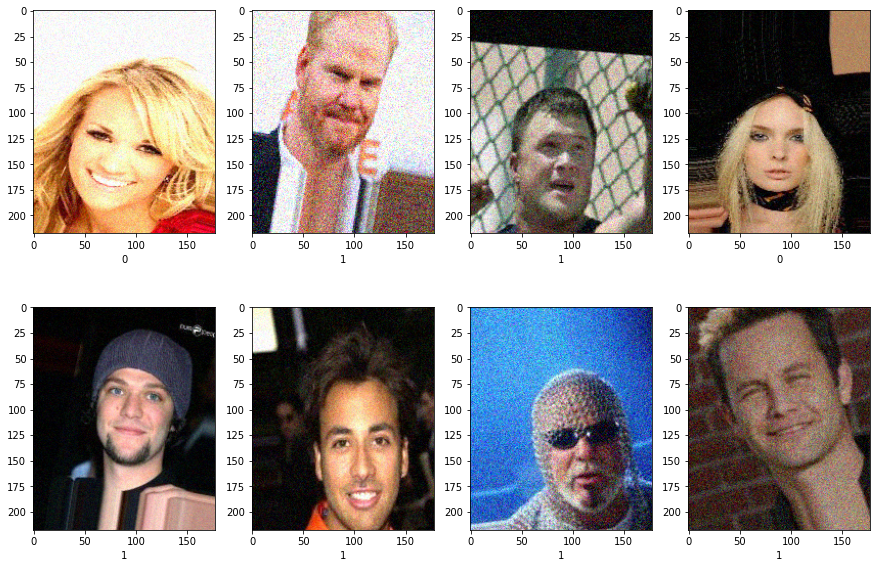

In [5]:
# Show photos of men's dataset
img, label = train.next()

fig = plt.figure(figsize=(15,10))
for i in range(1,9):
    plt.subplot(2,4,i)
    plt.imshow(img[i])
    plt.xlabel( int(label[i]))
plt.show()

# Build Model RestNet 50


In [8]:
input_shape = (218, 178, 3)

model = ResNet50(input_shape=input_shape, weights='imagenet',include_top=False)
for i,layer in enumerate(model.layers):
    print(i,layer.name)
print("\nInput:", model.input)
print("Output:", model.output)

0 input_2
1 conv1_pad
2 conv1_conv
3 conv1_bn
4 conv1_relu
5 pool1_pad
6 pool1_pool
7 conv2_block1_1_conv
8 conv2_block1_1_bn
9 conv2_block1_1_relu
10 conv2_block1_2_conv
11 conv2_block1_2_bn
12 conv2_block1_2_relu
13 conv2_block1_0_conv
14 conv2_block1_3_conv
15 conv2_block1_0_bn
16 conv2_block1_3_bn
17 conv2_block1_add
18 conv2_block1_out
19 conv2_block2_1_conv
20 conv2_block2_1_bn
21 conv2_block2_1_relu
22 conv2_block2_2_conv
23 conv2_block2_2_bn
24 conv2_block2_2_relu
25 conv2_block2_3_conv
26 conv2_block2_3_bn
27 conv2_block2_add
28 conv2_block2_out
29 conv2_block3_1_conv
30 conv2_block3_1_bn
31 conv2_block3_1_relu
32 conv2_block3_2_conv
33 conv2_block3_2_bn
34 conv2_block3_2_relu
35 conv2_block3_3_conv
36 conv2_block3_3_bn
37 conv2_block3_add
38 conv2_block3_out
39 conv3_block1_1_conv
40 conv3_block1_1_bn
41 conv3_block1_1_relu
42 conv3_block1_2_conv
43 conv3_block1_2_bn
44 conv3_block1_2_relu
45 conv3_block1_0_conv
46 conv3_block1_3_conv
47 conv3_block1_0_bn
48 conv3_block1_3_bn

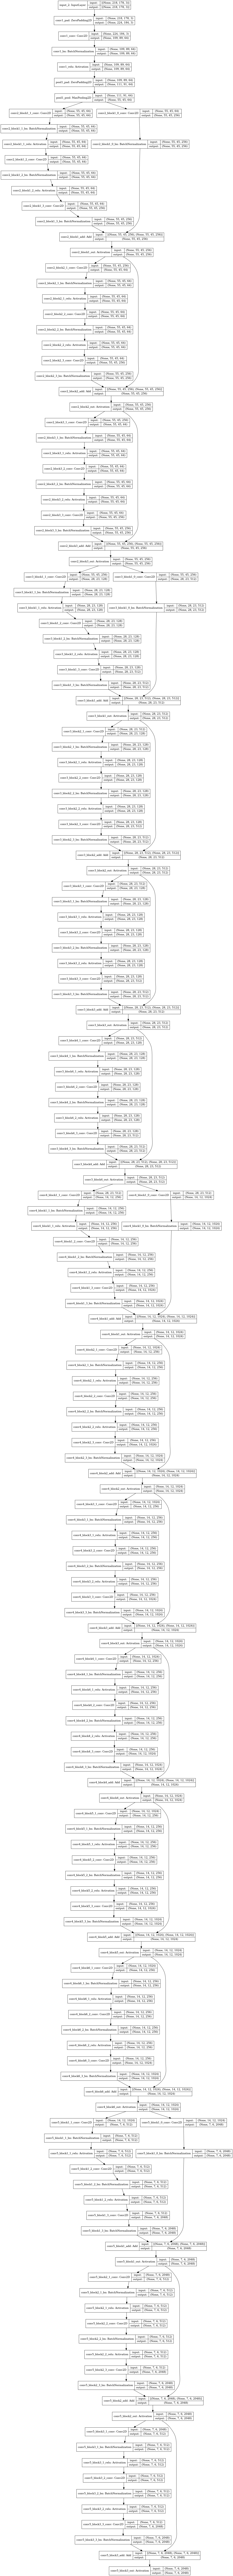

In [6]:
# Visualation Resnet 50 architecture
from tensorflow.keras.utils import plot_model
plot_model(model,show_shapes=True, show_layer_names=True, rankdir='TB', expand_nested=True)

# Fine Turning Parameters by Grid Search

In [ ]:
# Set data for fine tuning
X_f = []
y_f = []
for i in range(20):
    img, label = next(train)
    X_f.append(img)
    y_f.append(label)
X_fine_tuning = np.concatenate(X_f)
y_fine_tuning = np.concatenate(y_f)
print(len(X_fine_tuning))

In [ ]:
def define_model(learning_rate=0.0001, optimizer='Adam'):
    pre_trained_model = ResNet50(input_shape=(218, 178, 3), weights='imagenet',include_top=False)
    for layer in pre_trained_model.layers:
        layer.trainable = False
    last_output = pre_trained_model.output
    x = GlobalMaxPooling2D()(last_output)
    x = Dense(1024, activation='relu')(x)
    x = Dropout(0.2)(x)
    x = Dense(1, activation='sigmoid')(x)
    model = Model(inputs=pre_trained_model.input, outputs=x)
    model.compile(loss='binary_crossentropy',optimizer=optimizer, metrics=['accuracy'])
    return model

# Set parameters default
epochs=20
batch_size=32

model = KerasClassifier(build_fn=define_model, epochs=epochs,
                        batch_size=batch_size, verbose=0)

# List Parameters
optimizer = ['SGD', 'RMSprop', 'Adagrad', 'Adadelta', 'Adam', 'Adamax', 'Nadam', 'Ftrl']
learning_rate = [0.0001, 0.001, 0.01, 0.1]

param_grid = dict(optimizer=optimizer, learning_rate=learning_rate)

checkpoint_f = ModelCheckpoint('model_fine_tuning.h5', verbose =0, mode='auto', monitor = 'val_accuracy',
                               save_best_only = True)

grid = GridSearchCV(estimator=model, param_grid=param_grid, n_jobs=1, cv=3) #Máy mạnh thì n_jobs = -1
grid_result = grid.fit(X_fine_tuning, y_fine_tuning, callbacks=[checkpoint_f], validation_split=0.2)

# summarize results
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))

means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

# Train Model

In [9]:
input_shape = (218, 178, 3)
pre_trained_model = ResNet50(input_shape=input_shape, weights='imagenet',include_top=False)

for layer in pre_trained_model.layers:
    layer.trainable = False
    
last_output = pre_trained_model.output
# Flatten the output layer to 1 dimension
x = GlobalMaxPooling2D()(last_output)
# Add a fully connected layer with 1024 hidden units and ReLU activation
x = Dense(1024, activation='relu')(x)
# Dropout layer to reduce overfitting
x = Dropout(0.4)(x)
# Add a final sigmoid layer for classification
x = Dense(1, activation='sigmoid')(x)

model = Model(inputs=pre_trained_model.input, outputs=x)

model.compile(keras.optimizers.Adagrad(learning_rate=0.001), 
              loss = 'binary_crossentropy', 
              metrics=['accuracy'])

model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 218, 178, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 224, 184, 3)  0           input_3[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 109, 89, 64)  9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 109, 89, 64)  256         conv1_conv[0][0]                 
______________________________________________________________________________________________

In [12]:
checkpoint = ModelCheckpoint('training_save.h5', verbose=1, mode='auto',
                                              monitor='val_accuracy',  
                                              save_best_only=True)

history = model.fit_generator(
    train,
    steps_per_epoch=len(train),
    epochs=20,
    validation_data=val,
    validation_steps=len(val),
    verbose=1,
    callbacks=[checkpoint])

Epoch 1/20
 17/178 [=>............................] - ETA: 15:24 - loss: 1.3461 - accuracy: 0.5057

/opt/conda/lib/python3.7/site-packages/PIL/Image.py:993: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


178/178 [==============================] - 1171s 7s/step - loss: 1.0212 - accuracy: 0.5196 - val_loss: 0.7019 - val_accuracy: 0.5158

Epoch 00001: val_accuracy improved from -inf to 0.51585, saving model to training_save.h5


/opt/conda/lib/python3.7/site-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 2/20
178/178 [==============================] - 797s 4s/step - loss: 0.7163 - accuracy: 0.5750 - val_loss: 0.6684 - val_accuracy: 0.5526

Epoch 00002: val_accuracy improved from 0.51585 to 0.55260, saving model to training_save.h5
Epoch 3/20
178/178 [==============================] - 791s 4s/step - loss: 0.6390 - accuracy: 0.6294 - val_loss: 0.6109 - val_accuracy: 0.6472

Epoch 00003: val_accuracy improved from 0.55260 to 0.64717, saving model to training_save.h5
Epoch 4/20
178/178 [==============================] - 847s 5s/step - loss: 0.6151 - accuracy: 0.6554 - val_loss: 0.5863 - val_accuracy: 0.6876

Epoch 00004: val_accuracy improved from 0.64717 to 0.68759, saving model to training_save.h5
Epoch 5/20
178/178 [==============================] - 806s 5s/step - loss: 0.6002 - accuracy: 0.6747 - val_loss: 0.5717 - val_accuracy: 0.7340

Epoch 00005: val_accuracy improved from 0.68759 to 0.73403, saving model to training_save.h5
Epoch 6/20
178/178 [==============================] 

In [14]:
print(history.history.keys())

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:17: MatplotlibDeprecationWarning: The 'b' parameter of grid() has been renamed 'visible' since Matplotlib 3.5; support for the old name will be dropped two minor releases later.
  app.launch_new_instance()


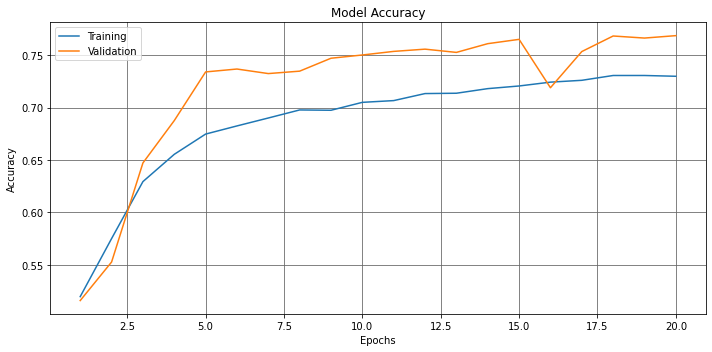

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:29: MatplotlibDeprecationWarning: The 'b' parameter of grid() has been renamed 'visible' since Matplotlib 3.5; support for the old name will be dropped two minor releases later.


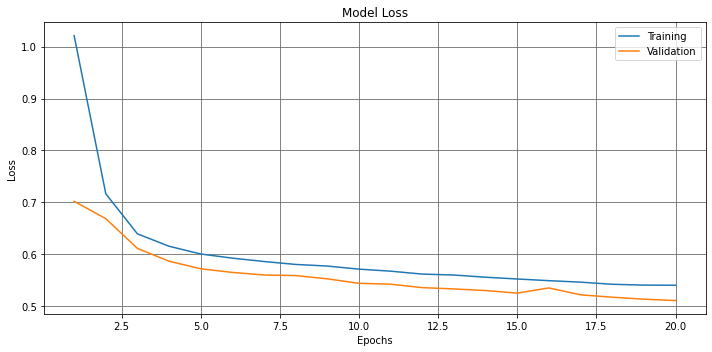

In [15]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(1, len(history.epoch) + 1)


plt.figure(figsize=(10,5))

plt.plot(epochs_range, acc, label='Training')
plt.plot(epochs_range, val_acc, label='Validation')
plt.legend(loc="best")
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Model Accuracy')
plt.grid(b=True, which='major', color='#666666', linestyle='-')
plt.tight_layout()
plt.show()

plt.figure(figsize=(10,5))

plt.plot(epochs_range, loss, label='Training')
plt.plot(epochs_range, val_loss, label='Validation')
plt.legend(loc="best")
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Model Loss')
plt.grid(b=True, which='major', color='#666666', linestyle='-')
plt.tight_layout()
plt.show()

In [ ]:
np.save('resnet_history.npy',history.history)

# Evaluation On Test Set

In [16]:
test_datagen = ImageDataGenerator(rescale=1./255)
test = test_datagen.flow_from_directory(directory='../input/large-gender-face-dataset/big_face_gender_data/Test',
                                          target_size=shape, batch_size=batch_size,
                                          class_mode='binary', color_mode='rgb', shuffle=True)

Found 16779 images belonging to 2 classes.


In [17]:
predictions = []
labels = []
for i in range(len(test)):
    x, y = next(test)
    pre = model.predict(x)
    pre = [1 if x > 0.5 else 0 for x in pre]
    predictions.append(pre)
    labels.append(y)
predictions = np.concatenate(predictions)
labels = np.concatenate(labels)
print(len(predictions))

16779


              precision    recall  f1-score   support

         0.0       0.73      0.83      0.78      8320
         1.0       0.81      0.70      0.75      8459

    accuracy                           0.77     16779
   macro avg       0.77      0.77      0.76     16779
weighted avg       0.77      0.77      0.76     16779

Confusion matrix, without normalization
[[6936 1384]
 [2553 5906]]


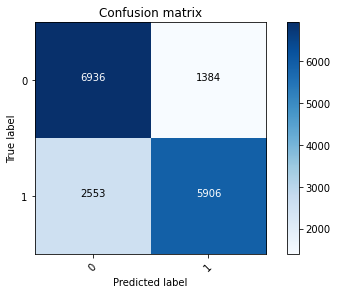

In [18]:
from sklearn.metrics import classification_report, confusion_matrix
import itertools
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
   
#--------------------------------------------------------------------------------------------------
    
# Compute confusion matrix
cnf_matrix = confusion_matrix(labels, predictions, labels=[0,1])
np.set_printoptions(precision=2)

print (classification_report(labels, predictions))

# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=['0','1'],normalize= False,  title='Confusion matrix')

In [19]:
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import accuracy_score


# Tính accuracy: (tp + tn) / (p + n)
accuracy = accuracy_score(labels, predictions)
print('Accuracy: %f' % accuracy)
# Tính precision tp / (tp + fp)
precision = precision_score(labels, predictions, average='macro')
print('Precision: %f' % precision)
# Tính recall: tp / (tp + fn)
recall = recall_score(labels, predictions, average='macro')
print('Recall: %f' % recall)
# Tính f1: 2 tp / (2 tp + fp + fn)
f1 = f1_score(labels, predictions, average='macro')
print('F1 score: %f' % f1)
# Tính Area under ROC
auc = roc_auc_score(labels, predictions, multi_class='ovr')
print('ROC AUC: %f' % auc)

Accuracy: 0.765361
Precision: 0.770551
Recall: 0.765923
F1 score: 0.764474
ROC AUC: 0.765923


In [20]:
# Saving model
model.save('model_test.h5')
print('Done! Model Saved!')

/opt/conda/lib/python3.7/site-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Done! Model Saved!


In [ ]:
# Load model
from tensorflow import keras
model = keras.models.load_model('../input/my-data/gender_classification_VGG16_95_percent_accuracy.h5')